#Imports

In [2]:
%tensorflow_version 1.x
import keras
import tensorflow as tf
import numpy as np
import keras.backend as K

#from keras.engine.topology import Layer
from tensorflow.keras.layers import Layer #, InputSpec

from keras.layers import Conv2D, AveragePooling2D, pooling, BatchNormalization, Activation  # , UpSampling2D ,concatenate, SeparableConv2D
#from keras.layers.advanced_activations import ThresholdedReLU

# import tensorflow as tf
# import numpy as np
import PIL.Image as Image
# import argparse
import matplotlib.pyplot as plt
import time
import cv2

from tensorflow.keras import datasets, layers, models

import numpy as np
import pywt
from matplotlib.image import imread
# import matplotlib.pyplot as plt
import os
import math
from google.colab.patches import cv2_imshow

UsageError: Line magic function `%tensorflow_version` not found.


#Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
# Checking if succesful
# !ls /content/gdrive/My\ Drive
%cd './gdrive/MyDrive/Texture_syn/'

ModuleNotFoundError: No module named 'google.colab'

# Arguments

In [4]:
image1 = 'bubbly_0038.jpg'
#Texture54.png
layer_S = 3
Iter = 3000
layer_D = 9
Adam = 0
mean = 1
inner = 10
Gau = 0.000001
save_weights = 0
Scale = 1e12
#im_dir = './gdrive/MyDrive/Texture_syn/Image/'
im_dir = './Image/'

In [7]:
image_path1 = im_dir+image1
I = Image.open(image_path1).resize((256,256)) #was 256,256
# I2 = cv2.imread(image_path1)

# Define class

In [35]:
class model1():
  def __init__(self, num_Com_layer):
    self.num_Com_layer = num_Com_layer
    
    self.Wave_List = list()
    self.Wave_List.append(Conv2D(32, (3,3),padding='same', name='convpool1'))
    self.Wave_List.append(AveragePooling2D((2, 2), strides=(2, 2), name='wavepool1'))

    self.Layer_List = list()
    
    self.Layer_List.append(Conv2D(32, (3, 3), padding='same', name='conv_wave_1'))
    # # self.Layer_List.append(Activation("relu",name = 'pool_ReLu1'))
    self.Layer_List.append(AveragePooling2D((2, 2), strides=(2, 2), name='block_wave1_pool1'))

    # self.Layer_List.append(Conv2D(32, (3, 3), padding='same', name='conv_wave_2'))
    # # self.Layer_List.append(Activation("relu",name = 'pool_ReLu2'))
    # self.Layer_List.append(AveragePooling2D((2, 2), strides=(2, 2), name='block_wave1_pool2'))

    self.Layer_List.append(Conv2D(128, (3,3),padding='same', name='conv1'))
    self.Layer_List.append(BatchNormalization(name='batch_norm1'))
    self.Layer_List.append(Activation("relu",name = 'relu1'))

    self.Layer_List.append(Conv2D(128, (3, 3), padding='same', name='conv2'))
    self.Layer_List.append(BatchNormalization(name='batch_norm2'))
    self.Layer_List.append(Activation("relu", name='relu2'))

    self.Layer_List.append(AveragePooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    self.Layer_List.append(Conv2D(128, (3, 3), padding='same', name='conv3'))
    self.Layer_List.append(BatchNormalization(name='batch_norm3'))
    self.Layer_List.append(Activation("relu", name='relu3'))

    self.Layer_List.append(Conv2D(128, (3, 3), padding='same', name='conv4'))
    self.Layer_List.append(BatchNormalization(name='batch_norm4'))
    self.Layer_List.append(Activation("relu", name='relu4'))

    self.Layer_List.append(AveragePooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    self.Layer_List.append(Conv2D(128, (3, 3), padding='same', name='conv5'))
    self.Layer_List.append(BatchNormalization(name='batch_norm5'))
    self.Layer_List.append(Activation("relu", name='relu5'))

    self.Layer_List.append(Conv2D(128, (3, 3), padding='same', name='conv6'))
    self.Layer_List.append(BatchNormalization(name='batch_norm6'))
    self.Layer_List.append(Activation("relu", name='relu6'))

    self.Layer_List.append(AveragePooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    self.High_res_com_list = list()
    self.High_res_com_list.append(Conv2D(32, (3,3), padding='same', dilation_rate=(1,1),  name='high_res_conv1'))
    self.High_res_com_list.append(BatchNormalization(name='batch_high_res_comm_1'))
    self.High_res_com_list.append(Conv2D(32, (3,3), padding='same', dilation_rate=(2,2),  name='high_res_conv2'))
    self.High_res_com_list.append(BatchNormalization(name='batch_high_res_comm_2'))

    self.Composite_List = list()
    self.scale = np.array([15, 35, 55, 75, 135])
    n = 32

    for i in range(num_Com_layer):
      self.Composite_List.append(Conv2D(n, 5, padding='valid', dilation_rate=int(self.scale[i] / 15),  name='conv1'+str(i)))
      self.Composite_List.append(BatchNormalization(name='batch_Com' + str(i)))

  def run(self, x):
      # Return the var list
      self.hid_dict = dict()

      # for i in range(int(len(self.High_res_com_list)/2)):
      #     tmp = self.High_res_com_list[i * 2](x)
      #     tmp = self.High_res_com_list[i * 2  + 1](tmp)
      #     self.hid_dict['high_res_composite' + str(i+1)] = tf.clip_by_value(tmp, 0, 1)

      # for i in range(len(self.Wave_List)):
      #     x = self.Wave_List[i](x)
      #     self.hid_dict[self.Wave_List[i].name] = x

      for i in range(self.num_Com_layer):
          tmp = self.Composite_List[i * 2](x)
          tmp = self.Composite_List[i * 2  + 1](tmp)
          self.hid_dict['composite' + str(i+1)] = tf.clip_by_value(tmp, 0, 1)

      for i in range(len(self.Layer_List)):
          x = self.Layer_List[i](x)
          if 'relu' in self.Layer_List[i].name:
              x = tf.clip_by_value(x, 0, 1)
          self.hid_dict[self.Layer_List[i].name] = x
      self.out = x

        
      self.var_list = list()

      # for i in range(len(self.Wave_List)):
      #     tmp = self.Wave_List[i].trainable_weights
      #     for j in range(len(tmp)):
      #         self.var_list.append(tmp[j])
      
      # for i in range(len(self.High_res_com_list)):
      #     tmp = self.High_res_com_list[i].trainable_weights
      #     for j in range(len(tmp)):
      #         self.var_list.append(tmp[j])

      for i in range(len(self.Layer_List)):
          tmp = self.Layer_List[i].trainable_weights
          for j in range(len(tmp)):
              self.var_list.append(tmp[j])

      for i in range(len(self.Composite_List)):
          tmp = self.Composite_List[i].trainable_weights
          for j in range(len(tmp)):
              self.var_list.append(tmp[j])


      return self.out, self.hid_dict, self.var_list, self.num_Com_layer



# Functions

In [14]:
def gram_matrix(feature_maps):
	"""Computes the Gram matrix for a set of feature maps."""
	batch_size, height, width, channels = tf.unstack(tf.shape(feature_maps))
	denominator = tf.cast(height * width, dtype=tf.float32)
	feature_maps = tf.reshape(feature_maps, tf.stack([batch_size, height * width, channels]))
	matrix = tf.matmul(feature_maps, feature_maps, adjoint_a=True)
	return matrix / denominator


def gram_loss(feature1, reference):
	F1 = gram_matrix(feature1)
	F2 = gram_matrix(reference)
	loss = tf.reduce_mean((F1 - F2) ** 2)
	return loss

	
def mean_loss(feature1, reference):
	m1 = tf.reduce_mean(feature1, axis=(1,2))
	#print(m1.shape)
	m2 = tf.reduce_mean(reference, axis=(1,2))
	loss = tf.reduce_mean(tf.square(m1 - m2))
	return loss

In [15]:
!ls ./gdrive/MyDrive/Texture_syn/

ls: cannot access './gdrive/MyDrive/Texture_syn/': No such file or directory


# WAVELETS

In [66]:
# import numpy as np
# import pywt
# from matplotlib.image import imread
# import matplotlib.pyplot as plt
# import os
# import math
# import cv2
# from google.colab.patches import cv2_imshow

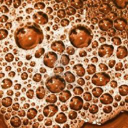

In [41]:
# Im = np.array(I, dtype=np.float)
# cv2_imshow(Im)

In [14]:
# b = Im[:,:,0]
# g = Im[:,:,1]
# r = Im[:,:,2]

# r = pywt.dwt2(r, 'haar')
# g = pywt.dwt2(g, 'haar')
# b = pywt.dwt2(b, 'haar')

In [15]:
# r_LL = np.asarray(r[0])
# g_LL = np.asarray(g[0])
# b_LL = np.asarray(b[0])
# r_HH = np.asarray(r[1][0])
# r_HL = np.asarray(r[1][1])
# r_LH = np.asarray(r[1][2])
# g_HH = np.asarray(g[1][0])
# g_HL = np.asarray(g[1][1])
# g_LH = np.asarray(g[1][2])
# b_HH = np.asarray(b[1][0])
# b_HL = np.asarray(b[1][1])
# b_LH = np.asarray(b[1][2])

In [16]:
# rgb_LL_minimized = np.zeros((int(Im.shape[0]/2),int(Im.shape[1]/2),3))

# rgb_HH_minimized = np.zeros((int(Im.shape[0]/2),int(Im.shape[1]/2),3))
# rgb_HL_minimized = np.zeros((int(Im.shape[0]/2),int(Im.shape[1]/2),3))
# rgb_LH_minimized = np.zeros((int(Im.shape[0]/2),int(Im.shape[1]/2),3))

# # rgb for plt, bgr for cv2
# rgb_LL_minimized[:,:,0] = np.add(rgb_LL_minimized[:,:,0], r_LL)
# rgb_LL_minimized[:,:,1] = np.add(rgb_LL_minimized[:,:,1], g_LL)
# rgb_LL_minimized[:,:,2] = np.add(rgb_LL_minimized[:,:,2], b_LL)

# rgb_HH_minimized[:,:,0] = np.add(rgb_HH_minimized[:,:,0], r_HH)
# rgb_HH_minimized[:,:,1] = np.add(rgb_HH_minimized[:,:,1], g_HH)
# rgb_HH_minimized[:,:,2] = np.add(rgb_HH_minimized[:,:,2], b_HH)

# rgb_HL_minimized[:,:,0] = np.add(rgb_HL_minimized[:,:,0], r_HL)
# rgb_HL_minimized[:,:,1] = np.add(rgb_HL_minimized[:,:,1], g_HL)
# rgb_HL_minimized[:,:,2] = np.add(rgb_HL_minimized[:,:,2], b_HL)

# rgb_LH_minimized[:,:,0] = np.add(rgb_LH_minimized[:,:,0], r_LH)
# rgb_LH_minimized[:,:,1] = np.add(rgb_LH_minimized[:,:,1], g_LH)
# rgb_LH_minimized[:,:,2] = np.add(rgb_LH_minimized[:,:,2], b_LH)

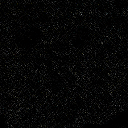

In [17]:
# cv2_imshow(rgb_LH_minimized)

In [18]:
# I = rgb_LL_minimized

# run model

In [36]:
loaded_image_array1 = np.array(I, dtype=np.float) / 255

img_nrows, img_ncols, _ = loaded_image_array1.shape

AVE = np.average(loaded_image_array1, axis=(0, 1))
image_processed = loaded_image_array1 - AVE

ref = tf.expand_dims(tf.constant(image_processed, dtype=tf.float32), axis=0)

x = tf.Variable(np.random.randn(3, img_nrows, img_ncols, 3), dtype=tf.float32)


In [37]:
# model construction
model = model1(layer_S)

In [38]:
out, h_dict, var_list, _ = model.run(x)
out_ref, h_dict_ref, _, _ = model.run(ref)

In [39]:
# layer_name = ['wavepool1']
layer_name = []
layer_name += ['block_wave1_pool1']
# layer_name += ['wavepool1']
layer_name_ = ['relu1', 'relu2', 'block1_pool', 'relu3', 'relu4', 'block2_pool', 'relu5', 'relu6', 'block3_pool', 'relu7', 'relu8', 'block4_pool', 'relu9', 'relu10', 'block5_pool']
layer_name += layer_name_[0:layer_D]
# layer_name += ['high_res_composite1','high_res_composite2']
layer_c = ['composite1', 'composite2', 'composite3', 'composite4', 'composite5']
layer_name += layer_c[0: layer_S]

In [40]:
layer_name

['block_wave1_pool1',
 'relu1',
 'relu2',
 'block1_pool',
 'relu3',
 'relu4',
 'block2_pool',
 'relu5',
 'relu6',
 'block3_pool',
 'composite1',
 'composite2',
 'composite3']

In [41]:
LOSS_LIST = []
for layer in layer_name:
	if mean == 0:
		tmp_loss = gram_loss(h_dict_ref[layer], h_dict[layer])
	else:
		tmp_loss = mean_loss(h_dict_ref[layer], h_dict[layer])
	LOSS_LIST.append(tmp_loss)
Loss = tf.add_n(LOSS_LIST)
Loss += tf.reduce_sum(x ** 2) * Gau
Loss *= Scale


In [42]:
if Adam == 0:
	op_I = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(Loss, var_list=x)
	op_w = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-Loss, var_list=var_list)
else:
	op_I = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.5, beta2=0.5).minimize(Loss, var_list=x)
	op_w = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.5, beta2=0.5).minimize(-Loss, var_list=var_list)

In [43]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())



G_vars = tf.global_variables()
G_g_vars = [var for var in G_vars if 'RMSProp' not in var.name and 'Adam' not in var.name]

saver = tf.train.Saver(var_list=G_g_vars, max_to_keep=5)

sample = x.get_shape()[0].value

In [44]:
start_time = time.time()

for i in range(Iter+1):

  for _ in range(inner):
    sess.run(op_I)

  sess.run(op_w)

  out = sess.run([x, Loss] + LOSS_LIST)
  
  current_time = time.time()

  print(i, out[1], out[2:], 'already used %ds' % (current_time - start_time))

  if i % 500 == 0:
    if save_weights == 1:
      s = saver.save(sess, 'SAVE_WEIGHT/' + image1 + '/', global_step=i, write_meta_graph=False)

    for j in range(sample):
      tmp = (np.clip(out[0][j] + AVE, 0, 1) * 255.).astype(np.uint8)
      
      # tmp_r_LL = tmp[:,:,0]
      # tmp_g_LL = tmp[:,:,1]
      # tmp_b_LL = tmp[:,:,2]

      # coef_r = (tmp_r_LL,[r_HH, r_HL, r_LH])
      # coef_g = (tmp_g_LL,[g_HH, g_HL, g_LH])
      # coef_b = (tmp_b_LL,[b_HH, b_HL, b_LH])
      # tmp_r = pywt.idwt2(coef_r, 'haar')
      # tmp_g = pywt.idwt2(coef_g, 'haar')
      # tmp_b = pywt.idwt2(coef_b, 'haar')

      # tmp = np.zeros((int(tmp_r.shape[0]), int(tmp_r.shape[1]), 3))
      # tmp[:,:,0] = np.add(tmp[:,:,0], tmp_r)
      # tmp[:,:,1] = np.add(tmp[:,:,1], tmp_g)
      # tmp[:,:,2] = np.add(tmp[:,:,2], tmp_b)

      # cv2_imshow(tmp)
      # tmp = [tmp_r, tmp_g, tmp_b]
      # cv2.imwrite('Produce/' + 'TEST_NEW' + image1 + '_' + 'inner_' + str(inner) + '_' +  '_layer_S_' + str(layer_S) + '_layer_D_' + str(layer_D) + '_IsMean_' + str(mean) + '_Adam_' + str(Adam) + '_' + str(j) + '_' + str(i) + '_' + '.jpg', tmp)
      plt.imsave('Produce/' + 'TEST_02_' + image1 + '_' + 'inner_' + str(inner) + '_' +  '_layer_S_' + str(layer_S) + '_layer_D_' + str(layer_D) + '_IsMean_' + str(mean) + '_Adam_' + str(Adam) + '_' + str(j) + '_' + str(i) + '_' + '.jpg', tmp)


0 1168671400000.0 [1.3385674e-06, 0.0016179845, 0.018786026, 0.018786026, 0.13165544, 0.17269982, 0.17269982, 0.019205881, 0.0033068832, 0.0033068827, 0.017924983, 0.017630994, 0.016568251] already used 15s
1 1354289500000.0 [1.5464884e-06, 0.0018202225, 0.018038308, 0.018038308, 0.10205519, 0.094156206, 0.094156206, 0.10872004, 0.1485209, 0.1485209, 0.019477317, 0.019004999, 0.017846828] already used 17s
2 2175519000000.0 [2.4305539e-06, 0.0018536616, 0.032018196, 0.032018196, 0.25630447, 0.27634594, 0.27634594, 0.2813374, 0.20185614, 0.20185614, 0.020814965, 0.020112524, 0.018919002] already used 18s
3 1387533400000.0 [4.7937187e-06, 0.0016015288, 0.005414512, 0.005414512, 0.030921035, 0.055773526, 0.055773526, 0.07805069, 0.27187464, 0.2718747, 0.021950915, 0.02108892, 0.019866318] already used 19s
4 3125301700000.0 [2.1772581e-05, 0.0017188288, 0.03471085, 0.03471085, 0.38576075, 0.35615826, 0.3561583, 0.42984, 0.4595224, 0.45952246, 0.02308721, 0.0219344, 0.02072808] already used 

# New Section

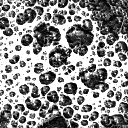

In [28]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# !git clone https://github.com/wzm2256/cgCNN.git
# %cd /content/cgCNN/image_synthesis/
# !python Synthesis.py bubbly_0038.jpg

# !ls

# cv2_imshow(tmp_b_LL)

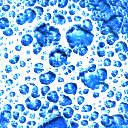

In [29]:

# tmp_LL = np.zeros((int(tmp_r_LL.shape[0]), int(tmp_r_LL.shape[1]), 3))
# tmp_LL[:,:,0] = np.add(tmp_LL[:,:,0], tmp_r_LL)
# tmp_LL[:,:,1] = np.add(tmp_LL[:,:,1], tmp_g_LL)
# tmp_LL[:,:,2] = np.add(tmp_LL[:,:,2], tmp_b_LL)
# cv2_imshow(tmp_LL)

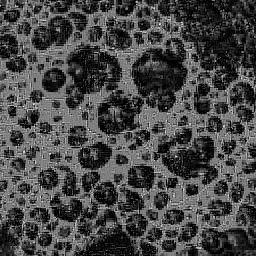

In [30]:
# cv2_imshow(tmp_b)

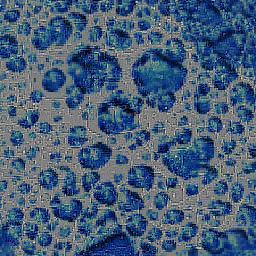

In [31]:
# I2 = cv2.resize(tmp, (256,256))
# cv2_imshow(I2)

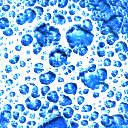

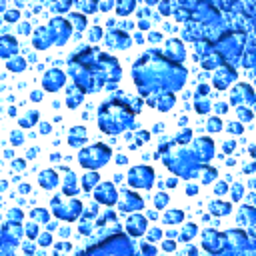

In [32]:
# cv2_imshow(tmp_LL)
# I2 = cv2.resize(tmp_LL, (256,256))
# cv2_imshow(I2)

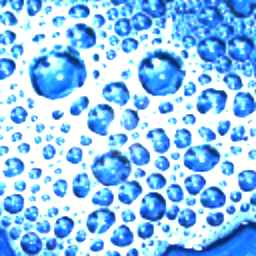

In [33]:
# I2 = cv2.resize(I,(256,256))
# cv2_imshow(I2)